## Description
This notebook demonstrates two methods for conducting [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation), which is a common image analysis technique used to transform a digital satellite image into objects. 
In brief, image segmentation aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. 
A number of algorithms exist to perform image segmentation, one of which are shown here:

1. [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift), implemented through the python package `scikit-image`

> **Note:** Image segmentation at very large scales can be both time and memory intensive, and the examples shown here will become prohibitively time consuming at scale. 
The notebook [Tiled, Parallel Image Segmentation](https://github.com/GeoscienceAustralia/dea-notebooks/blob/chad/segmentation/parallel_segmentation.ipynb) builds upon the image segmentation algorithm developed by [Shepherd et al. (2019)](https://www.mdpi.com/2072-4292/11/6/658) to run image segmentation across multiple cpus.

***

### Load packages

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from datacube.utils.cog import write_cog
from datacube.helpers import write_geotiff
from skimage.segmentation import quickshift, watershed
from skimage.filters import sobel
from sklearn import preprocessing

from skimage.segmentation import mark_boundaries
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb


## Load data

In [26]:
ds = xr.open_rasterio("/g/data/jk72/sc0554/floes/S2_20211028T174439_20211028T174433_T07DFA.tif")
# Convert our xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
input_array = ds.values.astype(np.float64).squeeze()
input_array = np.where(input_array == 0, np.nan, input_array)
# input_array = input_array[600:2000,500:2000]
input_array = input_array[1000:2000,600:1200]

/jobfs/83009783.gadi-pbs/ipykernel_2491965/115052243.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio("/g/data/jk72/sc0554/floes/S2_20211028T174439_20211028T174433_T07DFA.tif")


In [43]:
ds

<xarray.DataArray (variable: 1, band: 1, y: 3036, x: 2751)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -9.189e+05 -9.189e+05 ... -7.815e+05 -7.814e+05
  * y            (y) float64 1.203e+06 1.203e+06 ... 1.051e+06 1.051e+06
    spatial_ref  int64 ...
  * variable     (variable) object 'band_data'

In [47]:
image = '/g/data/jk72/sc0554/FSD/20220107T103149_20220107T103149_T24CWV.tif'
ds = xr.open_dataset(image).to_array()
# Convert our xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
# input_array = ds.values.astype(np.float64).squeeze()
input_array = ds.values.squeeze()
input_array = np.where(input_array == 0, np.nan, input_array)
# input_array = input_array[600:2000,500:2000]
# input_array = input_array[1000:2000,600:1200]

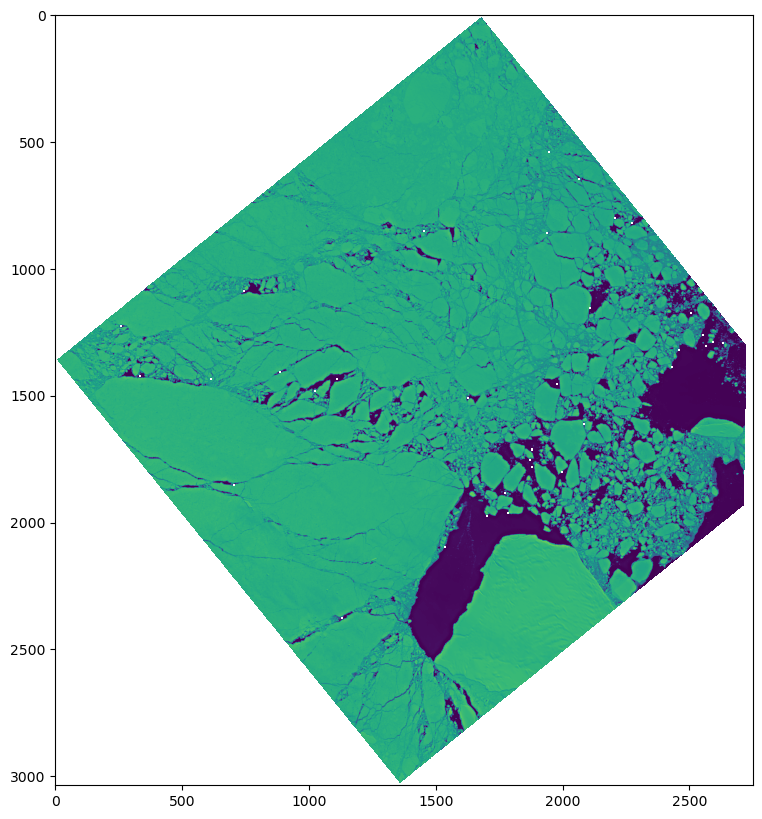

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(input_array)

## Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package `scikit-image`, we will conduct an image segmentation on the mean NDVI array.  We then calculate a zonal mean across each segment using the input dataset. Our last step is to export our results as a GeoTIFF.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in `scikit-image`.

In [49]:
min_max_scaler = preprocessing.MinMaxScaler()

scaled = min_max_scaler.fit_transform(input_array)

scaled

/g/data/jk72/sc0554/miniconda3/envs/sea-ice-segmentation/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/g/data/jk72/sc0554/miniconda3/envs/sea-ice-segmentation/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

(-0.5, 599.5, 999.5, -0.5)

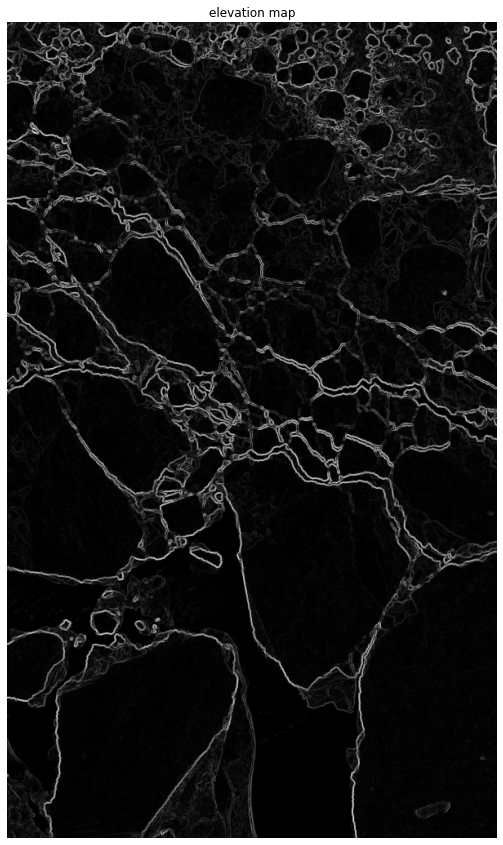

In [112]:
elevation_map = sobel(input_array)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.axis('off')

In [ ]:
# Calculate the segments
segments = quickshift(scaled,
                      kernel_size=17,
                      convert2lab=False,
                      max_dist=10,
                      ratio=0.5)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(scaled, segments))

In [8]:
# Calculate the segments
segments = quickshift(scaled,
                      kernel_size=20,
                      convert2lab=False,
                      max_dist=10,
                      ratio=1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


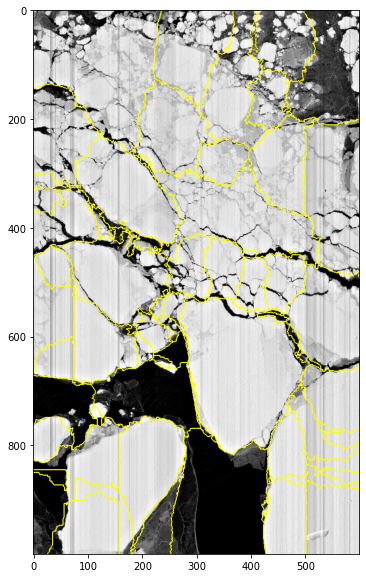

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(scaled, segments))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


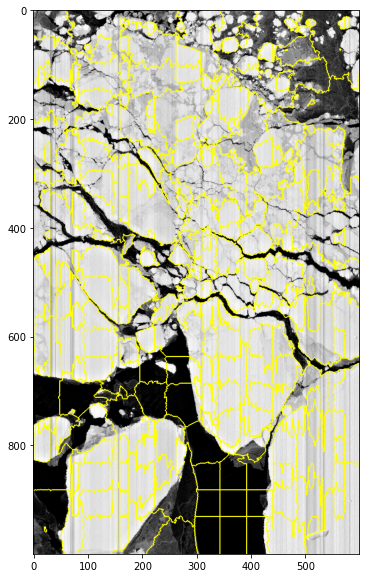

In [6]:
plt.figure(figsize=(10, 10))
segments_watershed = watershed(scaled, markers=250, compactness=0.001)
# plt.imshow(segments_watershed)
plt.imshow(mark_boundaries(scaled, segments_watershed))

In [91]:
# Calculate the zonal mean across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)


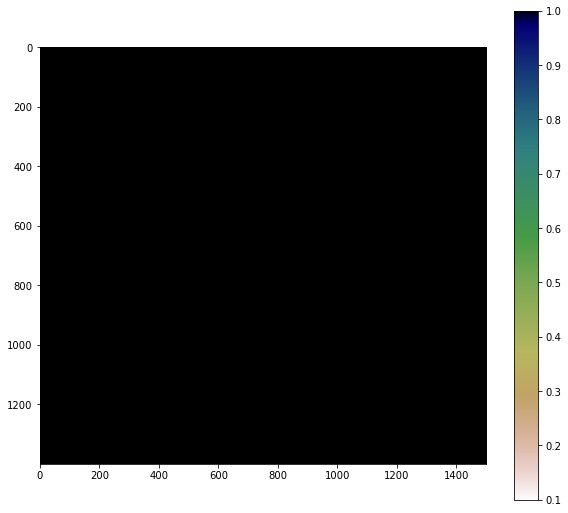

In [92]:
# Plot to see result
plt.figure(figsize=(10, 10))
plt.imshow(segments_zonal_mean_qs, cmap='gist_earth_r', vmin=0.1, vmax=1.0)
plt.colorbar(shrink=0.9)


### Export result to GeoTIFF
To export our result to a GeoTIFF raster file, we first need to convert our plain `np.array` back to an `xr.DataArray`, then use the `write_cog` function.

In [9]:
# Convert numpy array to xarray.DataArray
segments_zonal_mean_qs = xr.DataArray(segments_zonal_mean_qs, 
             coords=ndvi.coords, 
             dims=['y', 'x'], 
             attrs=ndvi.attrs)

# Write array to GeoTIFF
write_cog(geo_im=segments_zonal_mean_qs,
          fname='masked_data.tif',
          overwrite=True);